In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib import dates as mpl_dates
import pandas as pd
import os.path

plt.style.use('seaborn')


In [370]:
#install pytrends
!pip install pytrends


In [371]:
pd.set_option('display.float_format', '{:.5f}'.format)

In [372]:
covid_europe = pd.read_csv("../data_source/covid_europe.csv")

In [373]:
covid_europe.head()

,location,date,total_cases,new_cases,total_deaths,new_deaths,icu_patients,hosp_patients,total_tests,positive_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,life_expectancy,surface_area,population,employment_industry,internet_users,iso2,region
0,Austria,2020-02-25,2.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,81.54000,83871.00000,9006.00000,25.00000,87.50000,AT,Western Europe
1,Austria,2020-02-26,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,81.54000,83871.00000,9006.00000,25.00000,87.50000,AT,Western Europe
2,Austria,2020-02-27,3.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,81.54000,83871.00000,9006.00000,25.00000,87.50000,AT,Western Europe
3,Austria,2020-02-28,3.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,81.54000,83871.00000,9006.00000,25.00000,87.50000,AT,Western Europe
4,Austria,2020-02-29,9.00000,6.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,81.54000,83871.00000,9006.00000,25.00000,87.50000,AT,Western Europe


In [374]:
covid_europe["date"] = pd.to_datetime( covid_europe["date"] )

In [375]:
covid_europe = covid_europe.sort_values( ["location","date"] , ascending=True )

## Preguntas de negocio:

 - Según se inició el proceso de vacunas que cambio hubo en el comportamiento de nuevos casos, y nuevos deaths?
 - Según el inicio de aplicación de vacunas mensual como se compara con los nuevos casos.
 - Que tipo de score podemos asignar a cada país según el mes para evaluar el nivel progreso.

 


## Analisis descriptivo

Para iniciar este analisis comencemos excluyendo los meses donde no se tenia la informacion de vacunas, se realizara mediante la suma acumulada para no eliminar dias en el que tal ves hayan zero vacunas

In [376]:
covid_vaccine = covid_europe.loc[ covid_europe.total_vaccinations > 0 , : ].copy()

Primero calculemos la ultima actividad por pais

In [377]:
last_update = covid_vaccine.groupby(["location"], as_index=False).agg({ 'date' : ['max'] })
last_update.columns = last_update.columns.droplevel(1)

In [378]:
covid_vaccine_last_update = covid_vaccine.merge( last_update, on=["location","date"] , how="inner" )

In [379]:
covid_vaccine_last_update["Mortalidad_por_covid"] = covid_vaccine_last_update["total_deaths"] / (covid_vaccine_last_update["population"]*1000)

Primero identifiquimos cuales son los paises con una taza de mortalidad mas alta especificamente por el COVID

{'whiskers': [<matplotlib.lines.Line2D at 0x26c1df1d130>,
 'caps': [<matplotlib.lines.Line2D at 0x26c1cea0790>,
 'boxes': [<matplotlib.lines.Line2D at 0x26c1df1d280>],
 'medians': [<matplotlib.lines.Line2D at 0x26c1d77eb20>],
 'fliers': [<matplotlib.lines.Line2D at 0x26c1d77e490>],
 'means': []}

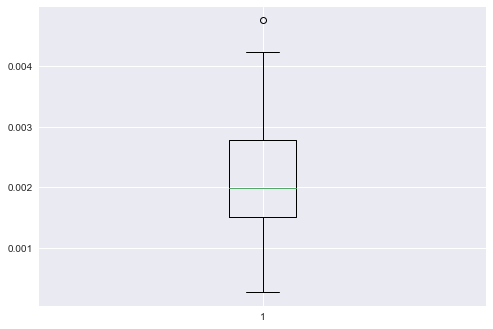

In [380]:
plt.boxplot(covid_vaccine_last_update["Mortalidad_por_covid"]) 

<ipython-input-381-9e0083d683fb>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(covid_vaccine_last_update["location"], rotation=90)


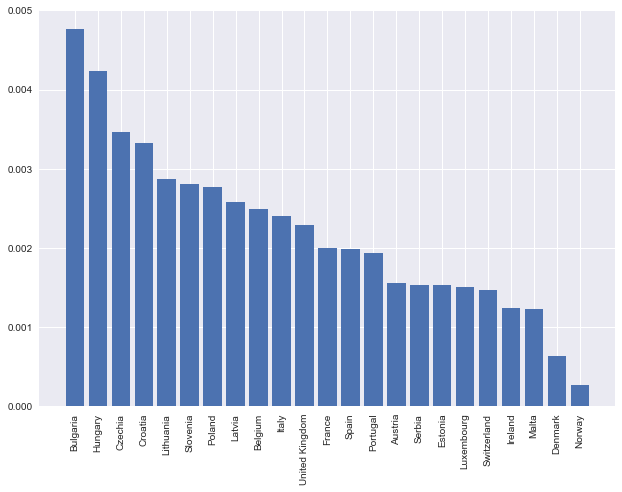

In [381]:
covid_vaccine_last_update = covid_vaccine_last_update.sort_values(["Mortalidad_por_covid"], ascending=False)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar( covid_vaccine_last_update["location"] , covid_vaccine_last_update["Mortalidad_por_covid"] )
ax.set_xticklabels(covid_vaccine_last_update["location"], rotation=90)
plt.show()


Como podemos observar Bulgaria es el pais con mayor taza de mortalidad basado en la proporcion de la poblacion total y la cantidad muertos debido al COVID

Hagamos este mismo Analisis usando como corte la region

In [382]:
covid_regions  = covid_vaccine.groupby(["region"],as_index=False).agg({ "total_deaths":["sum"] , "population" : ["sum"] })

In [383]:
covid_regions.columns = covid_regions.columns.droplevel(1)

In [384]:
covid_regions["Mortalidad_por_covid"] = covid_regions["total_deaths"] / (covid_regions["population"]*1000)

{'whiskers': [<matplotlib.lines.Line2D at 0x26c1e4a16d0>,
 'caps': [<matplotlib.lines.Line2D at 0x26c1e4a1910>,
 'boxes': [<matplotlib.lines.Line2D at 0x26c1e4a1a00>],
 'medians': [<matplotlib.lines.Line2D at 0x26c1fc5f400>],
 'fliers': [<matplotlib.lines.Line2D at 0x26c1e2f8c10>],
 'means': []}

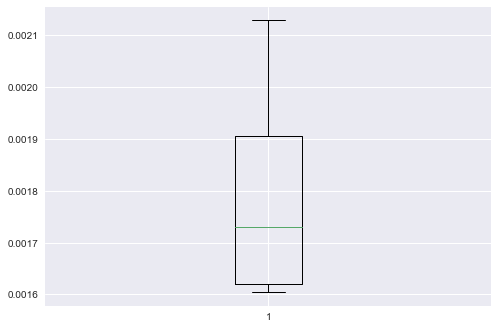

In [385]:
plt.boxplot(covid_regions["Mortalidad_por_covid"]) 

<ipython-input-386-f9a1999d6adc>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(covid_regions["region"], rotation=90)


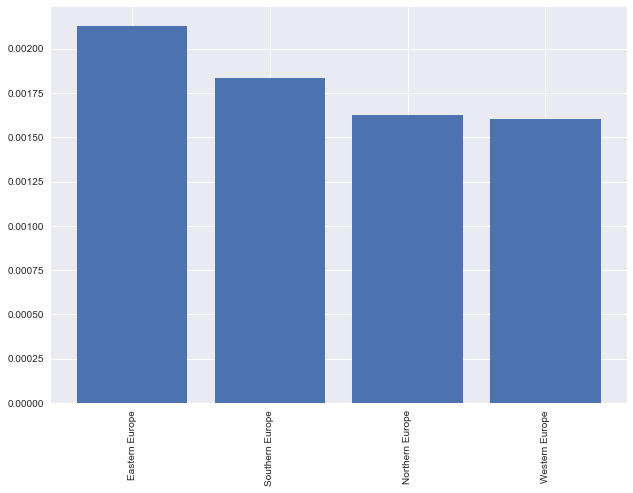

In [386]:
covid_regions = covid_regions.sort_values(["Mortalidad_por_covid"], ascending=False)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar( covid_regions["region"] , covid_regions["Mortalidad_por_covid"] )
ax.set_xticklabels(covid_regions["region"], rotation=90)
plt.show()

Por regiones no encontramos valores atipicos con respecto a su tasa de mortalidad.

### Segun nuestras variables cuales deberian de ser los paises que deberian de tener un mayor estudio, desde un punto de vista preliminar

- Por pais y mes como esta la mediana y la media de nuevos casos y nuevas muertes una ves se haya iniciado el proceso de vacunas

In [387]:
covid_vaccine["yearMonth"] = covid_vaccine['date'].dt.to_period('M')

In [388]:
covid_vaccine["yearMonth"] = covid_vaccine.apply( lambda r: "{0}-01".format( r["yearMonth"] ) ,axis=1 )

In [389]:
first_summary = covid_vaccine.groupby(["location","yearMonth"],as_index=False).agg({"new_cases":["mean","median"],"new_deaths":["mean","median"]})

In [390]:
first_summary["yearMonth"] = pd.to_datetime( first_summary["yearMonth"] )
first_summary.columns = first_summary.columns.droplevel(0)
first_summary.columns = ['location','yearMonth','new_cases_mean','new_cases_median','new_deaths_mean','new_deaths_median']

Lista de paises disponibles para poder interactuar

In [391]:
first_summary["location"].drop_duplicates()

0             Austria
14            Belgium
28           Bulgaria
42            Croatia
56            Czechia
70            Denmark
84            Estonia
98             France
112           Hungary
124           Ireland
138             Italy
152            Latvia
166         Lithuania
180        Luxembourg
194             Malta
207            Norway
221            Poland
235          Portugal
249            Serbia
262          Slovenia
276             Spain
289       Switzerland
303    United Kingdom
Name: location, dtype: object

In [392]:
def plot_two_lines( dataset , country , date , y1 , y2 , y1_label , y2_label , title ):
    c_ = country
    to_plot = dataset.loc[ dataset['location'] == c_ , : ]

    fig, ax = plt.subplots(figsize=(12,5))
    ax2 = ax.twinx()
    ax.set_title(title)    
    ax.plot(to_plot[date], to_plot[y1], color='blue', marker='x')
    ax2.plot(to_plot[date], to_plot[y2], color='red', marker='o')
    ax.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    ax.legend([y1_label])
    ax2.legend([y2_label], loc='upper center')
    ax.set_xticks(to_plot[date].dt.date)
    ax.set_xticklabels(to_plot[date], rotation=90)
    ax.yaxis.grid(color='lightgray', linestyle='dashed')
    plt.tight_layout()
    plt.show()

In [393]:
def find_trend( dataset ,country , ):
    
    min_date = np.min(dataset.loc[  first_summary["location"] == country  ,  "yearMonth" ])
    max_date = np.max(dataset.loc[  first_summary["location"] == country  ,  "yearMonth" ])
    
    geo_ = covid_vaccine.loc[ covid_vaccine['location'] == country , ["iso2"]  ].drop_duplicates().iloc[0,0]   
        
    #historical interest
    
    if( os.path.isfile("../data_source/trend_{0}.csv".format(country)) ):
        historicaldf = pd.read_csv("../data_source/trend_{0}.csv".format(country))
        historicaldf["date"] = pd.to_datetime( historicaldf["date"] )
    else:
        historicaldf = pytrend.get_historical_interest(
            ['Covid']
            , year_start = min_date.year, month_start =min_date.month, day_start =min_date.day, hour_start =0
            , year_end   = max_date.year, month_end   =max_date.month, day_end   =max_date.day, hour_end   =0
            , cat=0
            , geo=geo_
            , gprop=''
            , sleep=0
        )    
        historicaldf.to_csv("../data_source/trend_{0}.csv".format(country))

    #visualise
    #plot a timeseries chart
    
    historicaldf["date"] = historicaldf['date'].dt.to_period('M')
    historicaldf["date"] = historicaldf.apply( lambda r: "{0}-01".format( r["date"] ) ,axis=1 )
    historicaldf = historicaldf.groupby(["date"],as_index=False).agg({"Covid":["median",]})
    historicaldf["date"] = pd.to_datetime( historicaldf["date"] )
    
    
    fig, ax = plt.subplots(figsize=(12,5))
    ax2 = ax.twinx()
    ax.set_title("Tendencia de la palabra COVID atraves del  tiempo")    
    ax.plot(historicaldf["date"], historicaldf["Covid"], color='blue', marker='x')    
    ax.set_ylabel("Popularidad")
    ax.legend(["Popularidad"])

    ax.set_xticklabels(historicaldf["date"], rotation=90)
    ax.yaxis.grid(color='lightgray', linestyle='dashed')
    
    plt.tight_layout()
    plt.show()

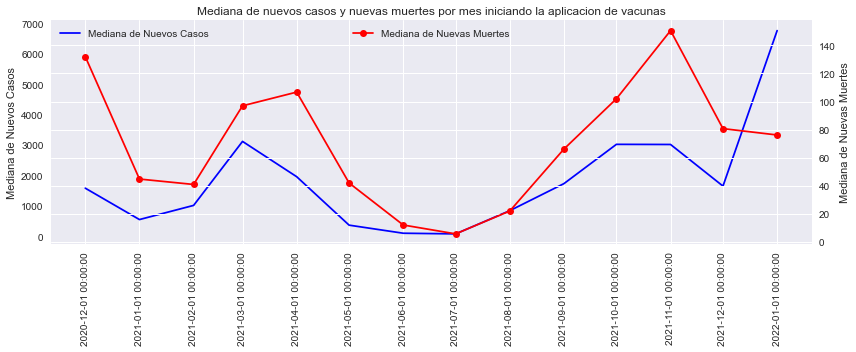

In [394]:
plot_two_lines(first_summary , "Bulgaria" , "yearMonth" , "new_cases_median" , "new_deaths_mean" , "Mediana de Nuevos Casos" , "Mediana de Nuevas Muertes" , "Mediana de nuevos casos y nuevas muertes por mes iniciando la aplicacion de vacunas" )

<ipython-input-393-114fd7609fdf>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(historicaldf["date"], rotation=90)


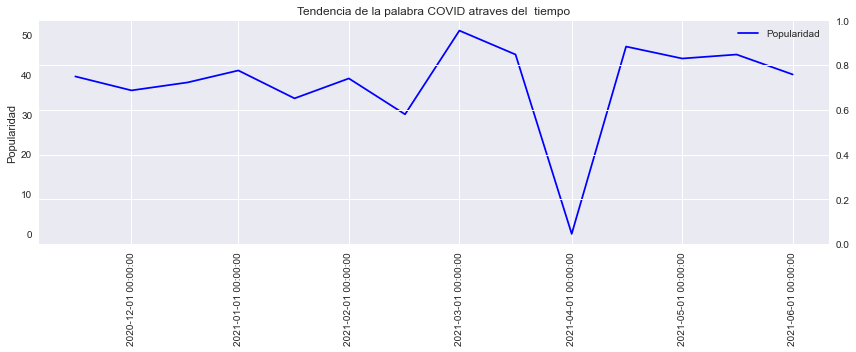

In [395]:
#### this function somethings return no data based on google network, in case of error you can re-run till 
find_trend( first_summary , "Bulgaria" ) 

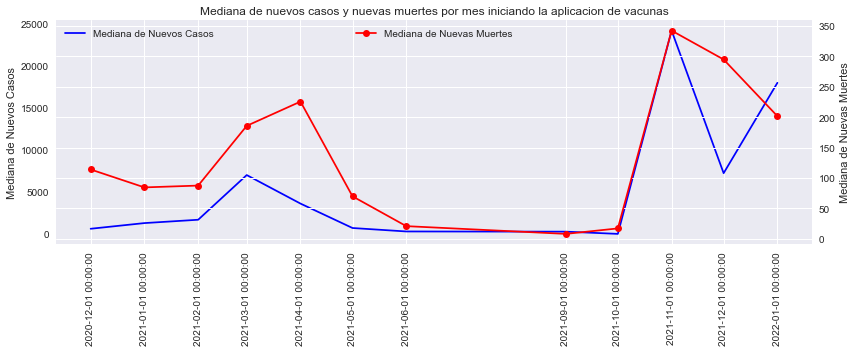

In [396]:
plot_two_lines(first_summary , "Hungary" , "yearMonth" , "new_cases_median" , "new_deaths_mean" , "Mediana de Nuevos Casos" , "Mediana de Nuevas Muertes" , "Mediana de nuevos casos y nuevas muertes por mes iniciando la aplicacion de vacunas" )

<ipython-input-393-114fd7609fdf>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(historicaldf["date"], rotation=90)


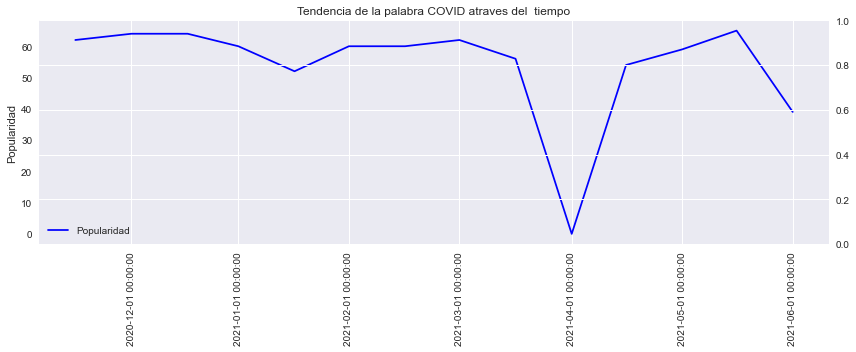

In [397]:
#### this function somethings return no data based on google network, in case of error you can re-run till 
find_trend( first_summary , "Hungary" ) 

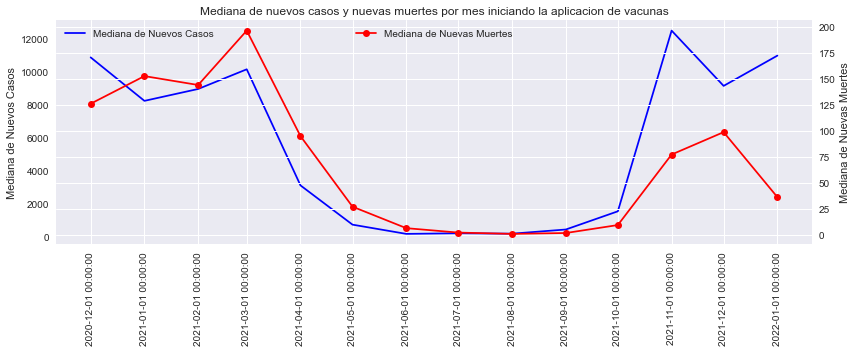

In [398]:
plot_two_lines(first_summary , "Czechia" , "yearMonth" , "new_cases_median" , "new_deaths_mean" , "Mediana de Nuevos Casos" , "Mediana de Nuevas Muertes" , "Mediana de nuevos casos y nuevas muertes por mes iniciando la aplicacion de vacunas" )

<ipython-input-393-114fd7609fdf>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(historicaldf["date"], rotation=90)


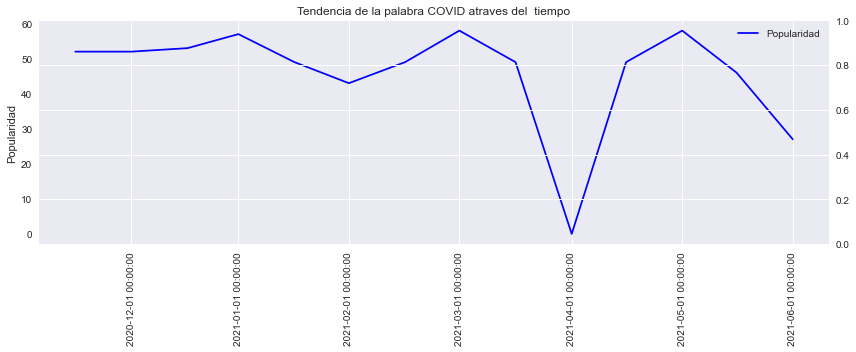

In [399]:
#### this function somethings return no data based on google network, in case of error you can re-run till 
find_trend( first_summary , "Czechia" ) 

Para la mayoría de los ejemplos que se seleccionaron se puede observar la tendencia de que una vez que se inició aplicar las vacunas la mediana de nuevas muertes empezaron a desacelerar de manera más rápida, por lo que si se observó un comportamiento positivo, ahora en los tres casos también se comparte que en cierto punto ambas tendencias se mantienen un poco constante, para el caso de reino unido el crecimiento de nuevos casos es más grande que la de muertos, justo lo que se esperaba ya que la vacuna da cierto nivel de protección. sin embargo, para otros países el crecimiento tiene una pendiente casi igual para ambas tendencias.

Vale recalcar que lo que buscamos en un comportamiento de crecimiento, no se puede concluir que hubo más muertos aunque las gráficas lo muestre visualmente, esta es una técnica que nos ayuda analizar la aceleracion ya sea en crecimiento o decrecimiento.

Por otro lado se intento comparar el nivel de popularidad de la palabra COVID para los rangos de fecha analizado en cada unos de los ejemplos, visualmente no se ve una tendencia puntal en los tres casos se observa que hay una decaida casi al mismo tiempo que los casos empiezan a disminuir.

- Segun el inicio de aplicacion de vacunas mensual como se compara con los nuevos casos.

para tener una variable que sea comparable a la de nuevos casos, se debe de hacer el calculo de cuantas vacunas se ponen al dia, utilizaremos como partida la variable acumulada

In [400]:
second_summary = covid_vaccine.loc[: , ["location","date","new_cases","total_vaccinations"] ]

Restamos el acumulado por el LEAD Window para saber el valor exacto de vacunas diarias

In [401]:
second_summary['new_vaccinations'] = second_summary.loc[:, ['total_vaccinations']]  - second_summary.groupby(['location'],as_index=False)['total_vaccinations'].shift(1).fillna(0)

Realizamos nuestras agregaciones para trabajar a nivel de mes

In [402]:
second_summary = second_summary.loc[ second_summary.total_vaccinations > 0 , : ].copy()

In [403]:
second_summary["date"] = second_summary['date'].dt.to_period('M')
second_summary["date"] = second_summary.apply( lambda r: "{0}-01".format( r["date"] ) ,axis=1 )
second_summary = second_summary.groupby(['location','date'],as_index=False).agg({"new_vaccinations":["median"],"new_cases":["median"]})
second_summary["date"] = pd.to_datetime( second_summary["date"] )

In [404]:
second_summary["date"] = pd.to_datetime( second_summary["date"] )
second_summary.columns = second_summary.columns.droplevel(0)
second_summary.columns = ['location','date','new_vaccinations_median','new_cases_median']

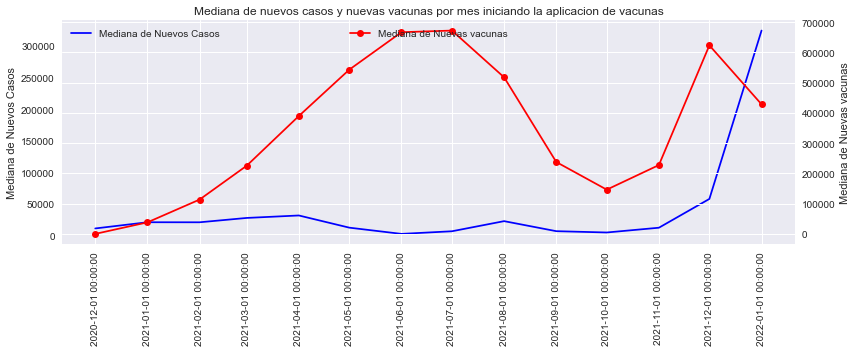

In [405]:
plot_two_lines(second_summary , "France" , "date" , "new_cases_median" , "new_vaccinations_median" , "Mediana de Nuevos Casos" , "Mediana de Nuevas vacunas" , "Mediana de nuevos casos y nuevas vacunas por mes iniciando la aplicacion de vacunas" )

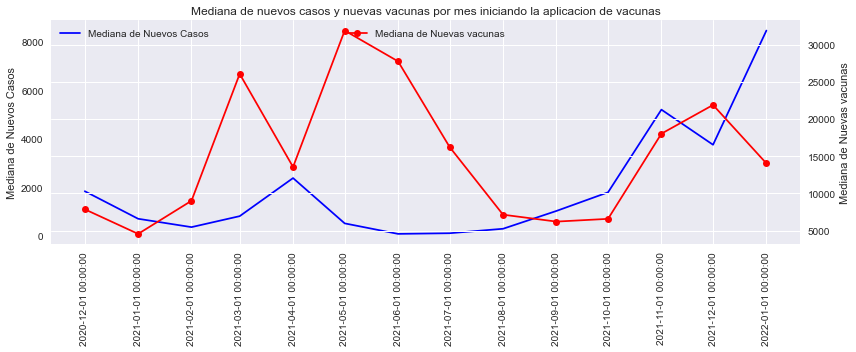

In [406]:
plot_two_lines(second_summary , "Croatia" , "date" , "new_cases_median" , "new_vaccinations_median" , "Mediana de Nuevos Casos" , "Mediana de Nuevas vacunas" , "Mediana de nuevos casos y nuevas vacunas por mes iniciando la aplicacion de vacunas" )

Para ammbos casos se puede observar que al principio vacunarse mantiene constante o disminuye la cantidad de nuevos casos, sin embargo, cuando los nuevos casos se levantan y las vacunas tambien como refuerzo no esta dando el efecto esperado de ver un cambio mas drastico que se introduce una nueva variante del COVID el cual es menos mortal



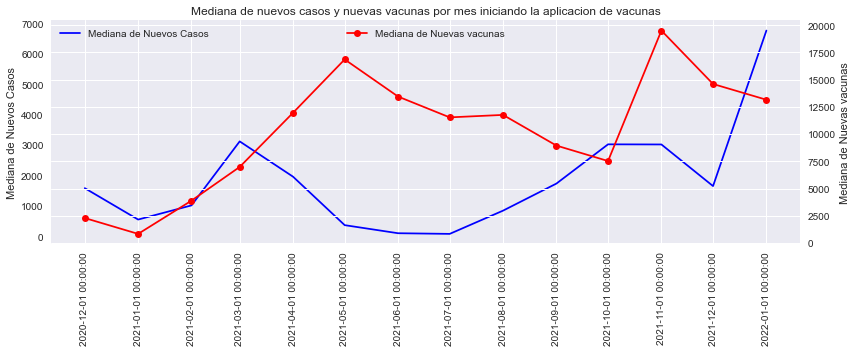

In [407]:
plot_two_lines(second_summary , "Bulgaria" , "date" , "new_cases_median" , "new_vaccinations_median" , "Mediana de Nuevos Casos" , "Mediana de Nuevas vacunas" , "Mediana de nuevos casos y nuevas vacunas por mes iniciando la aplicacion de vacunas" )

## Calculo del score

primero vamos a identificar y estandarizar las variables con las que vamos a trabajar:
- máximo valor acumulado de nuevos casos al mes (total_cases): para este caso vamos a calcular el cambio porcentual en relación con el mes anterior 
- máximo valor acumulado de muertes al mes (total_deaths): para este caso vamos a calcular el cambio porcentual en relación con el mes anterior 
- máximo valor acumulado de vacunas aplicadas en un mes (people_vaccinated): para este caso vamos a calcular el cambio porcentual en relación al mes anterior, este tiene la restricción de que algún momento se dejaran de aplicar vacunas por lo que se espera que el cambio porcentual de nuevos casos y muertes tiendan a uno.


In [460]:
covid_vaccine_to_sccore = covid_vaccine.loc[ : , ["location","date","total_cases","total_deaths","people_vaccinated"] ].copy()

Primero vamos a quedarnos con el ultimo valor que se encuentra en un mes para cada location

In [461]:
covid_vaccine_to_sccore['yearMonth'] = covid_vaccine_to_sccore['date'].dt.to_period('M')

In [462]:
df_  = covid_vaccine_to_sccore.groupby( ['location','yearMonth'], as_index=False ).agg( { "date" : ["max"] } )

In [463]:
df_.columns = df_.columns.droplevel(1)

In [464]:
df_ = df_.loc[ : , ["location","date"] ]

Ahora vamos a calcular cambio percentual de un mes a otro para nuestras tres variables

In [465]:
covid_vaccine_to_sccore = covid_vaccine_to_sccore.merge( df_ , on=["location","date"] , how="inner" )

In [466]:
covid_vaccine_to_sccore['total_cases_change_percentage'] = covid_vaccine_to_sccore.groupby(['location'],as_index=False)['total_cases'].shift(1) / covid_vaccine_to_sccore.loc[ : , ["total_cases"] ]

In [467]:
covid_vaccine_to_sccore['total_deaths_change_percentage'] = covid_vaccine_to_sccore.groupby(['location'],as_index=False)['total_deaths'].shift(1) / covid_vaccine_to_sccore.loc[ : , ["total_deaths"] ]

In [468]:
covid_vaccine_to_sccore['people_vaccinated_percentage'] = covid_vaccine_to_sccore.groupby(['location'],as_index=False)['people_vaccinated'].shift(1) / covid_vaccine_to_sccore.loc[ : , ["people_vaccinated"] ]

Limpiamos un poco nuestras variables

In [469]:
covid_vaccine_to_sccore = covid_vaccine_to_sccore.loc[ ~covid_vaccine_to_sccore['total_cases_change_percentage'].isna() , : ]

In [472]:
cols = ['location', 'date', 'total_cases', 'total_deaths', 'people_vaccinated', 'total_cases_change_percentage',
       'total_deaths_change_percentage', 'people_vaccinated_percentage']

In [474]:
covid_vaccine_to_sccore = covid_vaccine_to_sccore.loc[: , cols]

In [481]:
covid_vaccine_to_sccore['attention_score'] = covid_vaccine_to_sccore.loc[: , ['total_cases_change_percentage','total_deaths_change_percentage','people_vaccinated_percentage']].mean(axis=1)

In [483]:
austria = covid_vaccine_to_sccore.loc[ covid_vaccine_to_sccore['location'] == 'Austria' , : ]

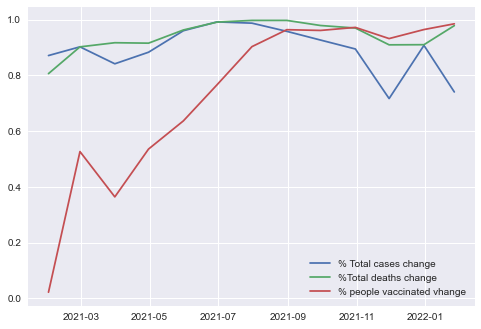

In [487]:
plt.plot(austria['date'], austria['total_cases_change_percentage'], label = "% Total cases change")
plt.plot(austria['date'], austria['total_deaths_change_percentage'], label = "%Total deaths change ")
plt.plot(austria['date'], austria['people_vaccinated_percentage'], label = "% people vaccinated vhange")
plt.legend()
plt.show()

Cada una de las líneas dan una interpretación sobre estabilidad de cada métrica evaluada, por ejemplo, entre más se acerca a uno el total de casos eso significa que no se están reportando nuevas. la misma lógica aplicaría para las muertes. ahora podemos ver casos interesantes como el de vacunas que tiene un crecimiento acelerado. Si analizamos el caso de que casos y muertes están cerca de uno, pero vacunas no, se puede interpretar como la entrada de una nueva variante del COVID y que la población debe volver a tener precaución. esa es la razón por la cual manejamos un único score para evaluar las tres métricas, ahora si analizamos el score total para este caso:

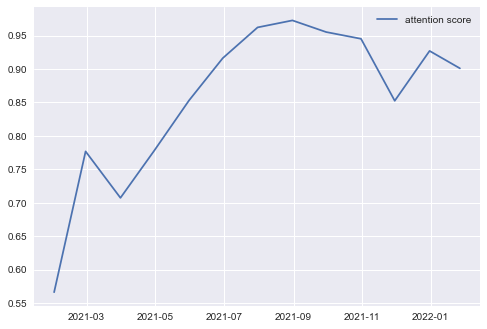

In [488]:
plt.plot(austria['date'], austria['attention_score'], label = "attention score")

plt.legend()
plt.show()

Como se puede observar, en diciembre para este caso el score bajo debido a las fiestas o eventos donde se junta la gente, en enero se vuelve a levantar la de vacuna como se observa en la aterior y estabiliza un poco mas el score.

In [491]:
Bulgaria = covid_vaccine_to_sccore.loc[ covid_vaccine_to_sccore['location'] == 'Czechia' , : ]

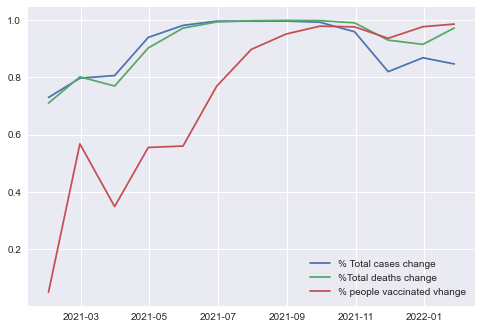

In [492]:
plt.plot(Bulgaria['date'], Bulgaria['total_cases_change_percentage'], label = "% Total cases change")
plt.plot(Bulgaria['date'], Bulgaria['total_deaths_change_percentage'], label = "%Total deaths change ")
plt.plot(Bulgaria['date'], Bulgaria['people_vaccinated_percentage'], label = "% people vaccinated vhange")
plt.legend()
plt.show()

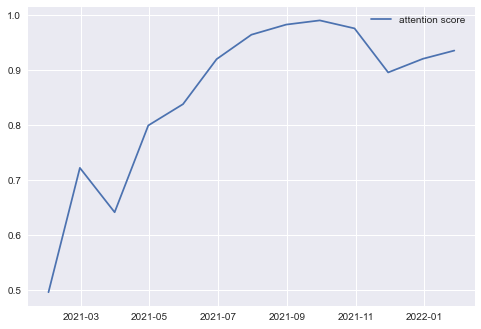

In [493]:
plt.plot(Bulgaria['date'], Bulgaria['attention_score'], label = "attention score")

plt.legend()
plt.show()

Este caso es muy interesante ya que desde octubre se empieza a decaer el score de atencion, esto es debido al aumento de casos nuevos y no asistencia de vacunas.

### Exortar dataset analitico para ser incorporado en el proceso de forecasting

In [494]:
covid_vaccine_to_sccore.to_csv("../data_source/training_set.csv",index_label=False)